# Neural Style Transfer

**Neural Style Transfer** (NST) is an application of deep learning, where we use neural networks to apply the artistic style of one image (e.g., a famous painting) to another image (e.g., a photograph), creating an output image that maintains the content of the second image but incorporates the style of the first.

**Neural Style Transfer** was first popularized by the paper A Neural Algorithm of Artistic Style by Gatys et al. http://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf The idea is to create a new image by combining:

* Content from one image (the "content image").
* Style from another image (the "style image").

The key idea is to represent both content and style in a way that can be separated and recombined:

* Content is captured by higher-level feature representations in a deep convolutional neural network (CNN).
* Style is captured by the textures and colors across different levels of the CNN.

The Loss Functions
* Content Loss: Measures the difference between the features of the generated image and the content image.
* Style Loss: Measures the similarity between the "textures" (or style) of the generated image and the style image, typically using Gram matrices to capture the correlation between different feature maps.

The goal is to minimize the combined content and style loss, which will produce an image that looks like the content image but incorporates the style of the style image.

The **Gram matrix** is a mathematical tool commonly used in Neural Style Transfer to capture the "style" of an image, which involves representing the textures, colors, and patterns in the image. In the context of a neural network, the Gram matrix captures correlations between different feature maps (or channels) in a given layer.

In convolutional neural networks (CNNs), each layer's feature map highlights different aspects of the image:

* Content layers focus on edges, shapes, and objects.
* Style is more about the patterns, textures, and color distributions that span across different spatial locations.

The Gram matrix helps to capture this texture information by representing the correlation between feature maps. When two feature maps (channels) are highly correlated, they frequently activate together, suggesting a recurring pattern or texture.

**Computing the Gram Matrix**

In Neural Style Transfer, the **Gram matrix** helps capture the "style" of an image by representing the correlation between different feature maps (or channels) in a given layer.

Suppose we have a feature map $ F $ from a certain layer in a neural network. $ F $ has dimensions of $ C \times H \times W $:
- $ C $: Number of channels (or feature maps).
- $ H $: Height of each feature map.
- $ W $: Width of each feature map.

To calculate the Gram matrix:

1. **Flatten each channel** of $ F $ into a vector of size $ H \times W $.
2. **Multiply** the flattened vector by its transpose to produce a $ C \times C $ matrix, where each element $ G_{ij} $ in the matrix is the dot product of the $ i $-th and $ j $-th channels of $ F $.

Mathematically, the Gram matrix $ G $ for feature map $ F $ is computed as:

$$
G = F \cdot F^T
$$

where:
- $ F $ is reshaped to have dimensions $ C \times (H \cdot W) $.
- $ F^T $ is the transpose of $ F $.

This process yields a $ C \times C $ matrix where each element $ G_{ij} $ measures how correlated feature maps $ i $ and $ j $ are.

![figures/gram_matrix.jpg](figures/gram_matrix.jpg)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms

# https://pytorch.org/vision/stable/models.html
from torchvision.models import vgg19, VGG19_Weights

import copy

In [2]:
# Check if a CUDA-capable GPU is available. If so, we use it for faster computations.
# If no GPU is available, fallback to using the CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the default device to the specified device (GPU if available, otherwise CPU).
# This ensures that all tensors are automatically created on this device unless specified otherwise.
torch.set_default_device(device)

In [3]:
# Define the desired output image size based on device availability
# If a GPU is available, we set the size to 512 for higher quality
# If only a CPU is available, we reduce the size to 128 to save processing time
imsize = 512 if torch.cuda.is_available() else 128  

# Define a transformation pipeline for preprocessing images before feeding them into the model
loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # Resize both dimensions explicitly to ensure consistency
    transforms.ToTensor()                 # Convert the image to a PyTorch tensor (scales pixel values to [0, 1])
])

# Define a function to load and preprocess an image
def image_loader(image_name):
    # Load the image using PIL, which handles various image file formats
    image = Image.open(image_name)
    
    # Apply the defined transformations (resize and convert to tensor)
    # .unsqueeze(0) adds an extra batch dimension, since PyTorch models expect input in batch format
    image = loader(image).unsqueeze(0)
    
    # Move the image tensor to the specified device (GPU or CPU) and set the data type to float
    return image.to(device, torch.float)

# Load the style and content images using the image_loader function
# These images will serve as the reference style and content images for style transfer
content_img = image_loader("./images/homelander.jpg")
style_img = image_loader("./styles/cubism2.jpg")

# Ensure that the style and content images have the same size, as this is required for style transfer
assert style_img.size() == content_img.size(), \
    "We need to import style and content images of the same size"


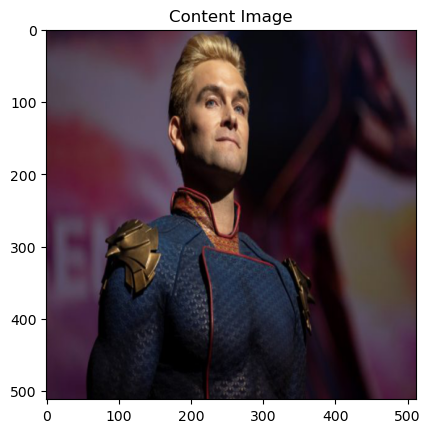

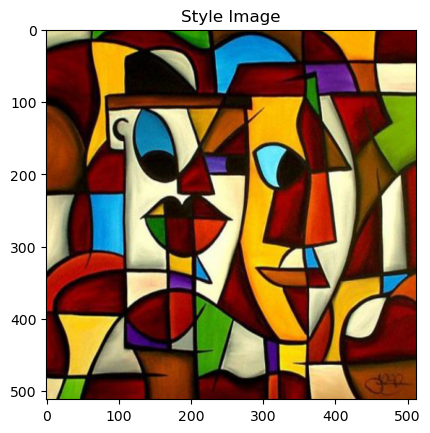

In [4]:
# Transformation to convert a PyTorch tensor back to a PIL image
unloader = transforms.ToPILImage()  # Converts a tensor to a PIL image format for display

# Turn on interactive plotting mode, allowing plots to be updated dynamically
plt.ion()

# Define a function to display a tensor as an image
def imshow(tensor, title=None):
    # Create a clone of the tensor and move it to the CPU for display
    image = tensor.cpu().clone()  # Clone to avoid modifying the original tensor
    
    # Remove the fake batch dimension (1, C, H, W) -> (C, H, W)
    image = image.squeeze(0)
    
    # Convert the tensor back to a PIL image for visualization
    image = unloader(image)
    
    # Display the image using Matplotlib
    plt.imshow(image)
    
    # Set the title of the plot, if provided
    if title is not None:
        plt.title(title)
    
    # Briefly pause to allow for interactive display updates
    plt.pause(0.001)  # Necessary for some environments to properly render the image

# Display the content image
plt.figure()  # Create a new figure for the content image
imshow(content_img, title='Content Image')  # Display the content image with a title

# Display the style image
plt.figure()  # Create a new figure for the style image
imshow(style_img, title='Style Image')  # Display the style image with a title

In [5]:
# Define a custom ContentLoss class that inherits from nn.Module
class ContentLoss(nn.Module):
    def __init__(self, target):
        """
        Initializes the ContentLoss module.

        Parameters:
        target (torch.Tensor): The target content features (extracted from the content image).
        """
        super(ContentLoss, self).__init__()
        
        # Detach the target content features from the computational graph.
        # This ensures the target content features are treated as fixed values,
        # preventing unnecessary gradient computations and errors during backpropagation.
        self.target = target.detach()
    
    def forward(self, input):
        """
        Computes the content loss between the input features and the target features.

        Parameters:
        input (torch.Tensor): The features of the generated image at a specific layer.

        Returns:
        torch.Tensor: The unchanged input tensor (to allow integration with the computation graph).
        """
        # Compute the Mean Squared Error (MSE) loss between the input features
        # (from the generated image) and the target content features.
        # This loss measures the difference in "content" between the generated
        # image and the content reference image.
        self.loss = F.mse_loss(input, self.target)
        
        # Return the input tensor unchanged to maintain compatibility with the model
        # and allow for chaining with other loss functions and transformations.
        return input

In [6]:
def gram_matrix(input):
    """
    Computes the Gram matrix for a given feature map tensor.
    The Gram matrix captures the correlation between different feature maps and is used to represent 'style' in style transfer.

    Parameters:
    input (torch.Tensor): A feature map tensor of shape (batch_size, num_feature_maps, height, width)

    Returns:
    torch.Tensor: The Gram matrix of the input feature map, normalized by the number of elements in each feature map.
    """
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [7]:
# Define a custom StyleLoss class that inherits from nn.Module
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        """
        Initializes the StyleLoss module.

        Parameters:
        target_feature (torch.Tensor): The feature maps of the style image at a specific layer.
        """
        super(StyleLoss, self).__init__()
        
        # Compute the Gram matrix of the target style feature maps
        # Detach it from the computation graph so it remains constant during optimization
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        """
        Computes the style loss between the input features and the target style features.

        Parameters:
        input (torch.Tensor): The feature maps of the generated image at the same layer as the target features.

        Returns:
        torch.Tensor: The unchanged input tensor (to allow integration with the computation graph).
        """
        # Compute the Gram matrix of the input feature maps (from the generated image)
        G = gram_matrix(input)
        
        # Calculate the Mean Squared Error (MSE) loss between the Gram matrix of the input and the target
        # This loss measures the difference in "style" (i.e., textures, patterns) between the generated
        # image and the style reference image
        self.loss = F.mse_loss(G, self.target)
        
        # Return the input tensor unchanged to allow this module to be integrated into the model seamlessly
        return input

In [8]:
# Load the pre-trained VGG19 model's feature extraction layers and set them to evaluation mode
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

In [9]:
# Define the mean and standard deviation values for normalizing the input image.
# These values are based on the ImageNet dataset, as the VGG19 model was trained on it.
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# Define a custom normalization module that inherits from nn.Module.
# This module will normalize an input image by adjusting its color channels
# based on the specified mean and standard deviation.
# So we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        """
        Initializes the Normalization module.

        Parameters:
        mean (list or tensor): Mean values for each color channel.
        std (list or tensor): Standard deviation values for each color channel.
        """
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        """
        Normalizes the input image.

        Parameters:
        img (torch.Tensor): An input image tensor of shape [B, C, H, W].

        Returns:
        torch.Tensor: The normalized image tensor.
        """
        # normalize ``img``
        return (img - self.mean) / self.std

In [10]:
# Define the default layers for computing content and style losses.
# These layers are chosen to capture different levels of feature representation.
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# Function to construct the style transfer model and track losses
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    """
    Builds the model with added normalization, style, and content loss layers.

    Parameters:
    cnn (nn.Module): The pre-trained CNN model (VGG19 features in this case).
    normalization_mean (torch.Tensor): Mean values for image normalization.
    normalization_std (torch.Tensor): Standard deviation values for image normalization.
    style_img (torch.Tensor): Style reference image tensor.
    content_img (torch.Tensor): Content reference image tensor.
    content_layers (list): List of layer names to compute content loss.
    style_layers (list): List of layer names to compute style loss.

    Returns:
    nn.Sequential: The constructed model with added normalization, style, and content loss layers.
    list: List of style loss layers.
    list: List of content loss layers.
    """
    
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)  # Name layers sequentially, e.g., 'conv_1', 'conv_2', etc.
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # Replace in-place (modify tensor directly) ReLU with out-of-place (create a new tensor) ReLU to avoid conflicts with loss layers
            # in-place ReLU modifies the original tensor directly, saving memory, while out-of-place ReLU leaves the original tensor unchanged,
            # ensuring compatibility with the backward pass and allowing safer handling in complex networks.
            # Some operations in the backward pass may require the original values. In-place operations can lead to issues
            # or errors in backward computations if they overwrite values needed for gradients.
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        # Add the layer to the model
        model.add_module(name, layer)

        # Add content loss if the current layer is in the list of content layers
        if name in content_layers:
            # Compute the target content features from the content image
            # .detach() is a method used to separate a tensor from the computation graph.
            # it creates a new tensor that shares the same data as the original tensor but does not require gradients
            # This "detached" tensor is no longer tracked by PyTorch's autograd, which means changes to it will not affect the original tensor,
            # and backpropagation will not compute gradients for it.
            target = model(content_img).detach() # Detach to avoid tracking gradients
            # Initialize a ContentLoss layer with the target features
            content_loss = ContentLoss(target)
            # Add the content loss layer to the model and the list
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)
        # Add style loss if the current layer is in the list of style layers
        if name in style_layers:
            # Compute the target style features from the style image
            target_feature = model(style_img).detach()
            # Initialize a StyleLoss layer with the target style features
            style_loss = StyleLoss(target_feature)
            # Add the style loss layer to the model and the list
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # Trim off layers beyond the last content or style loss layer
    # to save computation, as we do not need them for backpropagation
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    
    # Keep only the layers up to the last content or style loss
    model = model[:(i + 1)]

    return model, style_losses, content_losses

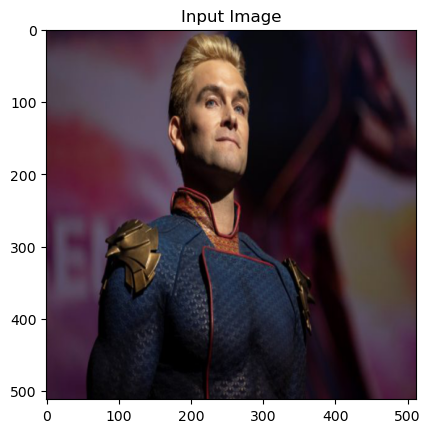

In [11]:
input_img = content_img.clone()
# if you want to use white noise by using the following code:
# input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [12]:
def get_input_optimizer(input_img):
    """
    Initializes the optimizer for the input image, which will be updated to minimize
    the content and style losses. This function uses the LBFGS optimizer, which is
    suitable for tasks like style transfer due to its performance on limited data.

    Parameters:
    input_img (torch.Tensor): The image tensor that will be optimized.

    Returns:
    torch.optim.Optimizer: The initialized LBFGS optimizer for the input image.
    """
    # LBFGS optimizer is chosen for style transfer tasks, as it is well-suited to
    # optimization problems with limited data. It minimizes the input image's content
    # and style losses by adjusting its pixel values.
    # The input image is wrapped in a list to specify it as a parameter requiring gradient updates.
    optimizer = optim.LBFGS([input_img.requires_grad_()])  # Set requires_grad to True
    
    return optimizer

In [13]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """
    Executes the style transfer process, optimizing the input image to minimize
    style and content losses and match the content of the content image and the style of the style image.

    Parameters:
    cnn (nn.Module): Pre-trained CNN model (e.g., VGG19 features).
    normalization_mean (torch.Tensor): Mean for input normalization.
    normalization_std (torch.Tensor): Standard deviation for input normalization.
    content_img (torch.Tensor): Content reference image.
    style_img (torch.Tensor): Style reference image.
    input_img (torch.Tensor): Starting image for optimization (content or random image).
    num_steps (int): Number of optimization steps.
    style_weight (float): Weight for the style loss in the optimization.
    content_weight (float): Weight for the content loss in the optimization.

    Returns:
    torch.Tensor: The optimized image tensor containing the final stylized image.
    """
  
    print('Building the style transfer model..')
    # Build the style transfer model and get style and content losses
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    # Set requires_grad_ for input_img to True so it can be optimized
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)  # Prevents gradient computation for model parameters

    # Initialize the optimizer for the input image
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]   # Using a list to allow modification within the closure
    # Optimization loop for the specified number of steps
    while run[0] <= num_steps:

        def closure():
            """
            This function performs a forward and backward pass, computes the losses,
            and applies a step of optimization.
            """
            # Clamp the values of input_img to [0, 1] to ensure valid pixel values
            with torch.no_grad():
                input_img.clamp_(0, 1)

            # Zero the gradients for this step
            optimizer.zero_grad()
            # Forward pass through the model with input_img to compute the losses
            model(input_img)
            style_score = 0
            content_score = 0
            
            # Accumulate style losses from each StyleLoss layer
            for sl in style_losses:
                style_score += sl.loss
            # Accumulate content losses from each ContentLoss layer
            for cl in content_losses:
                content_score += cl.loss

            # Scale the style and content losses by their respective weights
            style_score *= style_weight
            content_score *= content_weight

            # Total loss is the sum of style and content losses
            loss = style_score + content_score
            loss.backward()   # Compute gradients with respect to the input image

            # Print progress at every 50th step
            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        # Step the optimizer with the closure to perform optimization on input_img
        optimizer.step(closure)

    # Final clamping to ensure valid pixel values
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img  # Return the optimized image tensor with applied style

Building the style transfer model..
Optimizing..


D:\Other\Anaconda3\Lib\site-packages\torch\utils\_device.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


run [50]:
Style Loss : 527.315552 Content Loss: 19.425697

run [100]:
Style Loss : 125.263321 Content Loss: 21.010853

run [150]:
Style Loss : 51.908646 Content Loss: 21.159500

run [200]:
Style Loss : 30.911306 Content Loss: 21.371389

run [250]:
Style Loss : 21.900101 Content Loss: 21.566446

run [300]:
Style Loss : 16.762308 Content Loss: 21.675196



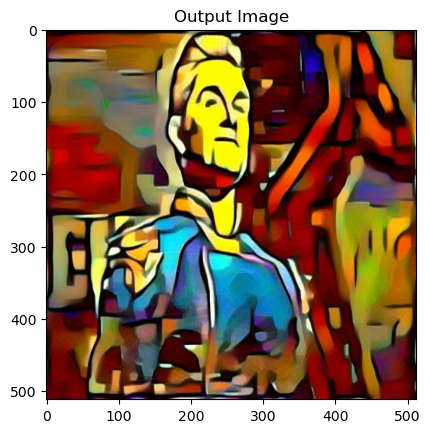

In [14]:
# Run the style transfer process using the defined function.
# This will return the optimized image with the style applied to the content.
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

# Display the final output image
plt.figure()  # Create a new figure for the output image
imshow(output, title='Output Image')  # Use the imshow function to display the styled image with a title

# Optionally, set a static plot for the gallery
# This line is for documentation purposes when using Sphinx gallery to generate thumbnails
# It won't affect the display in a standard Jupyter Notebook environment.
# sphinx_gallery_thumbnail_number = 4

# Turn off interactive mode to prevent further changes to the plot
plt.ioff()
plt.show()  # Show the plot with the styled output image